# Iteration 1<br/>*Establish a Baseline model*

Jupyter Notebook referenced from my website:
[Software Nirvana: Baseline Model (1a)](http://localhost:1313/2018/03/baseline-model-1a/)

### Goals
1. Create initial model
2. Demonstrate details of Scikit Learn's cross_val_score(), confusion_matrix() and accuracy_score()
4. Compare initial model to null model

### Iterative Model Development
In order to demonstrate iterative model development, the titanic dataset from Kaggle will be used.

The purpose of these notebooks is **not** to teach how to predict on the titanic dataset!  There are many Kaggle kernels available for that.  The purpose of this series of notebooks is to illustrate iterative model development in general and to show the specifics of how various Scikit Learn methods work.

The model will make a prediction for Survived / Not-Survived.  This is a supervised classification problem.

Several notebooks will be created after this one.  Each iteratively improving:
* the model's accuracy
* the workflow used to create the model

<a name="outline"></a>
### Outline
1. [Acquire and Read Data](#readdata)
2. [Identify Target Variable](#target)
3. [Tentative Assumptions For 1st Iteration](#assumptions)
4. [Exploratory Data Analysis](#eda)
5. [Model Building](#model)
6. [Model Evaluation: Train/Test Split](#traintest)
7. [Model Evaluation: Confusion Matrix](#confusion)
8. [Model Evaluation: Cross Validation](#crossvalidation)
9. [Model Summary](#modelsummary)
0. [Summary](#summary)

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Software Versions
If your versions are earlier than shown below, you may need to upgrade your software to produce the same results.  On Linux, using the Anaconda distribution, this is done by:
```
source activate <env>
conda update conda
conda update --all
```

In [2]:
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)

python:      3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
numpy:       1.14.2
pandas:      0.22.0
matplotlib:  2.2.2
seaborn:     0.8.1
sklearn:     0.19.1


<a name="readdata"></a>
### Acquire the Data
[Back to Outline](#outline)

Download "train.csv" from: https://www.kaggle.com/c/titanic/data and place it in a data subdirectory.

This link also has the data dictionary (sometimes called the codebook).

### Read in Data
Note that this example is for supervised learning, so we will only deal with labeled data.  The labeled dataset is named "train.csv".

In [3]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')
all_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<a name="target"></a>
### Target Variable: Survived
[Back to Outline](#outline)

Create two variables from the data we read in preparation for creating a predictive model.  

X: A Pandas DataFrame that represents the features (aka attributes)  
y: A Pandas Series that represents the target (aka response)  

In [4]:
# X: drop target variable
# y: keep only the target
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']
print('X Shape: ', X.shape)
print('y Shape: ', y.shape)
print('X Type: ', type(X))
print('y Type: ', type(y))

X Shape:  (891, 11)
y Shape:  (891,)
X Type:  <class 'pandas.core.frame.DataFrame'>
y Type:  <class 'pandas.core.series.Series'>


In [5]:
# ndim, as in numpy, reports the number of dimensions (e.g. 1D, 2D)
print('X dimensions: ',X.ndim)
print('y dimensions: ',y.ndim)

X dimensions:  2
y dimensions:  1


<a name="assumptions"></a>
### First Iteration Assumptions
[Back to Outline](#outline)  

In order to quickly get something up and running, let's arbitrarily decide upon the following:
* use LogisticRegression
* drop ID field
* drop all non-numeric features
* drop any column having a null value
* model evaluation metric: accuracy

Note that LogisticRegression requires all fields to be numeric and non-null.  Therefore we must either drop fields that don't meet these requirements or convert them to numeric fields.  Here we will drop them.  Later we will convert them to numeric.

In [6]:
X.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
# create a list of column names of type object
drop_fields = list(X.dtypes.index[X.dtypes.values == 'object'].values)
drop_fields

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [8]:
# IDs fields should almost never be features
drop_fields.append('PassengerId')
drop_fields

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']

In [9]:
# Remove all non-numeric fields and PassengerId (1st iteration only)
X = X.drop(drop_fields, axis=1)
X.dtypes

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

In [10]:
# which fields have null values
X.isnull().any()

Pclass    False
Age        True
SibSp     False
Parch     False
Fare      False
dtype: bool

In [11]:
# Remove all columns with null values (1st iteration only)
X.dropna(axis=1, inplace=True)
X.isnull().any()

Pclass    False
SibSp     False
Parch     False
Fare      False
dtype: bool

<a name="eda"></a>
### Initial Exploratory Data Analysis
[Back to Outline](#outline)

Examining the codebook (aka data dictionary) at: https://www.kaggle.com/c/titanic/data
shows that Pclass is an ordered categorical variable that happens to be encoded as an integer.  Let's take a quick look at how survival is related to passenger class.

In [12]:
# Determine percentage of survivors by class
# Survived = 1, Not Survived = 0
# mean() of Survived is the fraction that survived
all_data.groupby(['Pclass'])['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

The above shows that 63% of 1st class passengers survived, 47% of 2nd class passengers survived and 24% of 3rd class passengers survived.

Passenger class is not a continuous variable.  The distance between 1st class and 2nd class is not the same as the distance between 2nd class and 3rd class; in fact, the distance is not defined.  Nevertheless for predictive modeling purposes, given that the ordinal encoding matches its association with the target variable, leaving it encoded as an integer is a good approach.

Keep passenger class, which is an ordered categorical variable, encoded as an integer.

<a name="model"></a>
### Model Building
[Back to Outline](#outline)

Initially we will evaluate the model based on a single train/test split.  As this is part of the model building process, it is discussed here.

random_state is set so that the train/test split is always the same.  This allows anyone who executes this notebook to get the same results.  This is part of reproducible research.

stratify=y is used so that our train/test split has the same ratio of survived/not-survived in the train and test data sets, as exists in the y response data.

In [13]:
# create train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.30, stratify=y, random_state=10)

In [14]:
# let's verify that stratify=y worked as expected
print('All Data  Survived Fraction: {:.2f}'.format(y.mean()))
print('Train Set Survived Fraction: {:.2f}'.format(y_train.mean()))
print('Test  Set Survived Fraction: {:.2f}'.format(y_test.mean()))

All Data  Survived Fraction: 0.38
Train Set Survived Fraction: 0.38
Test  Set Survived Fraction: 0.38


Since the percentage of survived passengers is about the same in the entire data set, as it is in the train and test data sets, "stratify=y" worked as expected.  That is, it ensured the same frequency of each class value in each data set.

In [15]:
# Build Model on Train Data Set
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<a name="traintest"></a>
### Model Evaluation: Train/Test Split
[Back to Outline](#outline)

In [16]:
# Use model fitted on train data set to make predictions on test data set
predictions = base_model.predict(X_test)

# Compute accuarcy using sklearn
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

# Compute accuracy manually to be sure we understand accuracy_score()
print((y_test == predictions).mean())

0.6305970149253731
0.6305970149253731


We see that accuracy_score() gave us the same value as the determining the mean number of times the prediction for the test set was the same as the actual test set label.

Although it may seem confusing at first to see mean() used to compute the percentage of True values in a boolean collection, it is a commonly used idiom.

To fully understand what is happening, it is often helpful to look at the data types of the objects.  Let's look at the last line of code above in more detail.

In [17]:
print('Predictions Collection Type: ', type(predictions))
print('Predictions Value Type:      ', predictions.dtype)
print('Predictions Values:          ', np.unique(predictions))
print('y_test Collection Type:      ', type(y_test))
print('y_test Value Type:           ', y_test.dtype)
print('y_test Values:               ', y_test.unique())
print('Comparison Collection Type:  ', type(predictions == y_test))
print('Comparison Value Type:       ', (predictions == y_test).dtype)
print('Comparison Values:           ', (predictions == y_test).unique())
print('Accuracy:                     {:.4f}'.format((y_test == predictions).mean()))

Predictions Collection Type:  <class 'numpy.ndarray'>
Predictions Value Type:       int64
Predictions Values:           [0 1]
y_test Collection Type:       <class 'pandas.core.series.Series'>
y_test Value Type:            int64
y_test Values:                [0 1]
Comparison Collection Type:   <class 'pandas.core.series.Series'>
Comparison Value Type:        bool
Comparison Values:            [ True False]
Accuracy:                     0.6306


We see that:
* predictions, returned from predict(), is a numpy array of integers
* y, the response (or target) variable, is a Pandas Series
* comparisons between numpy arrays and Pandas Series are allowable
* this comparison results in a Pandas Series of type bool
* taking the mean of a boolean collection gives the percentage of True values

<a name="confusion"></a>
### Model Evalutation: Confusion Matrix
[Back to Outline](#outline)

For binary classification problems such as this, the following terms are often used:
<pre>
TP = True  Positive  
FP = False Positive 
TN = True Negative  
FN = False Negative
</pre>

Where "positive" in this example means "Survived".

TP means we predicted survived and that passenger did survive.  
FP means we predicted survived and the passenger did not survive.  
TN means we predicted not-survived and the passenger did not survive.  
FN means we predicted not-survived and the passenger did survive.

Accuracy is the number of true prediction divided by the total number of predictions:
(TN + TP) / (TN + FP + FN + TP)


For a binary classification problem, sklearn represents this as a [Confusion Matrix](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) as follows:

In [18]:
# sklearn confusion matrix
print("","TN", "FP\n","FN TP")

 TN FP
 FN TP


In [19]:
# For instructional purposes, let's derive the confusion matrix ourselves
TN = ((y_test == 0) & (predictions == 0)).sum()
FP = ((y_test == 0) & (predictions == 1)).sum()
FN = ((y_test == 1) & (predictions == 0)).sum()
TP = ((y_test == 1) & (predictions == 1)).sum()

my_confusion_matrix = np.array([[TN, FP],[FN, TP]])
print(my_confusion_matrix)

[[126  39]
 [ 60  43]]


In [20]:
# Use sklearn to compute the confusion_matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predictions)
print(confusion)

[[126  39]
 [ 60  43]]


We see that our hand-coded and sklearn confusion matrix results are the same.

In [21]:
# Compute Accuracy from Confusion Matrix
print('Accuracy: {:.4f}'.format((TN+TP)/(TN + FP + FN + TP)))

Accuracy: 0.6306


We see that we got the same accuarcy as before, about 63.1%.

<a name="crossvalidation"></a>
### Model Evaluation: Cross Validation
[Back to Outline](#outline)

Each time we randomly chose a different train and test subset of our data, we will get a different estimate of the model's accuracy.  If we do this only once, we risk having an unrepresentative train/test split.

A better approach is to take several train/test splits and compute the accuracy of each.  This is what Cross Validation does.

Good overview of cross validation and overfiting in Python:
* [Train/Test Split and Cross Validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
* [Learning Curves](https://www.dataquest.io/blog/learning-curves-machine-learning/)

Good overview of cross validation and overfitting in general:
* chapter 5.1 of [ISL](http://www-bcf.usc.edu/~gareth/ISL/)
* The first 3 videos for Chapter 5 [ISL Videos](http://www.dataschool.io/15-hours-of-expert-machine-learning-videos/)

In [22]:
from sklearn.model_selection import cross_val_score, KFold

# Recommended Values are 5 or 10
k_folds = 10

# For repeatability
random_seed=5

# Create the K Cross Validation Train/Test Splits
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# compute cross validated scores for each of the K=5 folds
scores = cross_val_score(base_model, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=-1)

# print results
print('Scores: \n', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

Scores: 
 [0.689 0.764 0.697 0.73  0.629 0.64  0.652 0.697 0.708 0.652]
Cross Validated Accuracy: 0.686


### cross_val_score()
The [cross_val_score()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) helper function does a lot.  Let's do exactly the same thing by hand to verify we understand it.

A [crossvalidation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object is returned from the call to KFold.

[crossvalidation.split(X)](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold.split) is an iterator which returns 2 numpy arrays, one set of indexes to define the train set and one set of indexes to define the test set.

Compute the accuracy score using the iterator and compare with cross_val_score().

In [23]:
# Alternative computation of cross validated scores

# From Above
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# Use crossvalidation iterator explicitly
my_scores = np.zeros(k_folds)
i = 0
lr_model = LogisticRegression()
for train_idx, test_idx in crossvalidation.split(X):
    
    # train subset
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    
    # test subset
    X_test = X.iloc[test_idx, :]
    y_test = y[test_idx]
    
    # fit model on train
    lr_model.fit(X_train, y_train)
    
    # predict using model on test
    predictions = lr_model.predict(X_test)
    
    # evaluate accuracy
    my_scores[i] = accuracy_score(y_test, predictions)
    i += 1

# print results
print('Scores: \n', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

# compare with scores computed by cross_val_score() above
print('Scores match: ',(scores == my_scores).all())

Scores: 
 [0.689 0.764 0.697 0.73  0.629 0.64  0.652 0.697 0.708 0.652]
Cross Validated Accuracy: 0.686
Scores match:  True


The scores match.  The computations are the same, however cross_val_score() required only 1 line of code whereas the alternative required more than 10 lines of code.

### Compare with Simplest Model
For a classifier, predicting the predominant class is the simplest possible model.  This is sometimes referred to as the "null model".

In [24]:
from sklearn.dummy import DummyClassifier

k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

null_model = DummyClassifier(strategy='most_frequent',random_state=0)

null_model_scores = cross_val_score(null_model, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=-1)

print('Scores: \n', np.round(null_model_scores, 3))
print(f'Cross Validated Accuracy: {null_model_scores.mean():.3f}')

Scores: 
 [0.6   0.64  0.629 0.674 0.551 0.607 0.607 0.596 0.64  0.618]
Cross Validated Accuracy: 0.616


The random_state used for KFold() is the same for both our LogisticRegression model and the null model.  This means we computed the scores over the same train/test splits.  This means we can compare the differences in each value to see which did better for a given training and test set.

In [25]:
diff_scores = scores - null_model_scores
print(f'CV Diff Scores: \n{np.round(diff_scores,3)}')
print(f'Mean diff: {diff_scores.mean():.3f}')

CV Diff Scores: 
[0.089 0.124 0.067 0.056 0.079 0.034 0.045 0.101 0.067 0.034]
Mean diff: 0.070


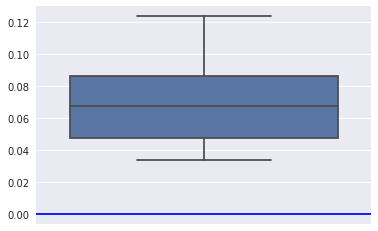

In [26]:
sns.boxplot(y=diff_scores)
plt.axhline(0, color='blue')

We see that every CV score was better for our simple Logistic Regression model than it was for the null model.

<a name="modelsummary"></a>
### Model Summary
[Back to Outline](#outline)

Model building steps only.

In [27]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# create target and feature variables
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# remove all fields of type object
drop_fields = list(X.dtypes.index[X.dtypes.values == 'object'].values)

# also remove the ID field
drop_fields.append('PassengerId')
X = X.drop(drop_fields, axis=1)

# remove the remaining column having null values
X = X.dropna(axis=1)

# create model instance
base_model = LogisticRegression()

# Recommended Values are 5 or 10
k_folds = 10

# For repeatability
random_seed=5

# Create the K Cross Validation Train/Test Splits
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# compute cross validated scores for each of the K=5 folds
scores = cross_val_score(base_model, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=-1)

# print results
print('Scores: \n', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

Scores: 
 [0.689 0.764 0.697 0.73  0.629 0.64  0.652 0.697 0.708 0.652]
Cross Validated Accuracy: 0.686


<a name="summary"></a>
### Summary
[Back to Outline](#outline)

In this first iteration we:
* discussed how Scikit Learn computes accuracy, the confusion matrix, and cross validation scores
* created a simple model to use as our baseline
* established a baseline accuracy of 68.5%
* created the simplest possible "null model" for comparison
* showed that our baseline model accuracy (68.5%) is better than the null model (61.6%)